# Set 2

Trapping of a amyloid-beta 40 (Aβ-40) fibril in a thermopheretic trap imaged by the fluorescence of thioflavin T (ThT).

<img src='Set2_001.png' width='300' alt='No Image Found'>

## Path to raw data
.72/Data/Martin/180423_A-Beta_Fibril_ThT_Trapping/Set2

In [1]:
dataset = 'Set2'

## Information about the sample preparation, experimental setup and the data sets

In [2]:
with open('Readme.txt') as f:
    info = f.read()               
#print(info)

## Required packages

In [3]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

import os, glob

import pandas as pd
import trackpy as tp
import pickle

from scipy import stats
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 18,
                     'axes.titlesize': 20,
                     'axes.labelsize': 20,
                     'axes.labelpad': 14,
                     'lines.linewidth': 3,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Useful functions

In [4]:
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [5]:
def rayleigh(x, a, sigma):
    return a*x*np.exp(-x**2/(2*sigma**2))/sigma**2

## Load tracking files and metadata 

Features where detected using the TrackerLab: https://github.com/MolecularNanophotonics/TrackerLab <br>
The tracking parameters are stored in a HDF5 files.

In [6]:
for file in glob.glob(dataset + '*_spots.h5'):
    print(file)

Set2_001_spots.h5
Set2_002_spots.h5
Set2_003_spots.h5
Set2_004_spots.h5
Set2_005_spots.h5
Set2_006_spots.h5
Set2_007_spots.h5
Set2_008_spots.h5
Set2_009_spots.h5
Set2_010_spots.h5
Set2_011_spots.h5
Set2_012_spots.h5


In [7]:
metadata = pd.read_hdf(dataset + '_001_spots.h5', 'metadata').to_dict('records')[0]
metadata

{'binning': 2,
 'dimx': 126,
 'dimy': 126,
 'exposure': 0.03,
 'frames': 1000,
 'pp_mask_r': 39,
 'pp_mask_x': 62,
 'pp_mask_y': 62,
 'pp_median': 2,
 'tt_area_max': 250,
 'tt_area_min': 10,
 'tt_method': 'Measure Labels',
 'tt_threshold': 280}

In [8]:
dimx = metadata['dimx']
dimy = metadata['dimy']
binning = metadata['binning']
exposure = metadata['exposure']
xm = metadata['pp_mask_x']
ym = metadata['pp_mask_y']
rm = metadata['pp_mask_r']

In [9]:
scale = 0.0577*binning

## Concatenate feature files

In [10]:
f = pd.DataFrame()
spots = pd.DataFrame()
for i, file in enumerate(glob.glob(dataset + '*_spots.h5')):
    spots = pd.read_hdf(file, 'spots')
    if i == 0:   
        f = spots
    else:
        spots['frame'] += f['frame'].max()
        f = f.append(spots)

In [11]:
f.head();

## Display the tracking data

In [12]:
display = True

if display:
    import ipywidgets as widgets

    def plot_features(i):
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        x0 = f[f['frame']==i].x.item()
        y0 = f[f['frame']==i].y.item()
        # plot major and minor axis
        orientation = f[f['frame']==i].orientation.item()
        x1 = x0 + np.cos(orientation)*0.5*f[f['frame']==i].major_axis_length.item()
        y1 = y0 - np.sin(orientation)*0.5*f[f['frame']==i].major_axis_length.item()
        x2 = x0 - np.sin(orientation)*0.5*f[f['frame']==i].minor_axis_length.item()
        y2 = y0 - np.cos(orientation)*0.5*f[f['frame']==i].minor_axis_length.item()
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.b', markersize=15)
        ax.set_xlim(xm-rm, xm+rm)
        ax.set_ylim(ym+rm, ym-rm) # inverted
        circle = plt.Circle((xm, ym), rm, color='k', lw=2, ls='--', fill=False)
        ax.add_patch(circle)

    widgets.interact(plot_features, i=widgets.BoundedIntText(value=0, min=0, max=f['frame'].max(), step=1, description='Frame:', disabled=False));

A Jupyter Widget

## Link trajectories

In [13]:
link = False

search_range = 25
memory = 3

# only link trajectories if there is no trajectories HDF5 file or if link is set true  
if not os.path.exists(dataset + '_trajectories.h5') or link: 
    t = tp.link_df(f, search_range=search_range, memory=memory) # depending on the number of frames this may take a while
    store = pd.HDFStore(dataset + '_trajectories.h5', 'w')
    store.put('trajectories', t)
    store.close()
else:
    with pd.HDFStore(dataset + '_trajectories.h5') as store:
        t = store['trajectories']
        store.close()


## Filter trajectories

Keep only trajectories that last for a given number of frames.

In [14]:
f = tp.filter_stubs(t, 10)
f.head();

## Max. intensity vs. time

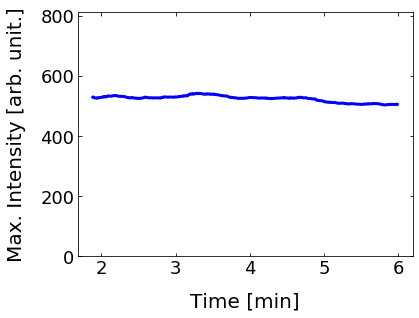

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6,4.5))

smoothed = f['max_intensity'].rolling(window=2500).mean() # rolling average
#ax.axhline(y=smooth.max(), c='0.5', ls='--', lw=2)
ax.plot(f['frame']*exposure/60, smoothed, 'b')
ax.set_ylim(0, 1.5*np.max(smoothed))
ax.set_xlabel('Time [min]')
ax.set_ylabel('Max. Intensity [arb. unit.]')
#plt.savefig('../../Figures/Max_Intensity_Time.pdf', bbox_inches='tight', pad_inches=0.025)
plt.show()

## Mean squared displacment

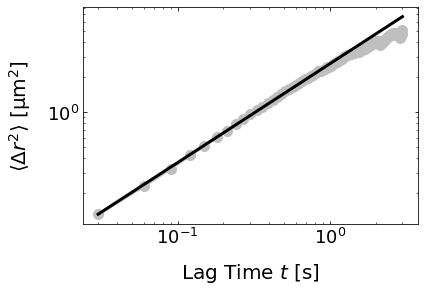

In [16]:
max_lagtime = 100
max_lagtime_fit = 1

emsd = tp.emsd(f, scale, 1/exposure, max_lagtime)
a, b = np.polyfit(np.log(emsd[emsd.index <= max_lagtime_fit].index), np.log(emsd[emsd.index <= max_lagtime_fit]), 1)

fig, ax = plt.subplots()
ax.plot(emsd.index, emsd, 'o-', color='0.75')
ax.plot(emsd.index, np.exp(b)*emsd.index**a, 'k-')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [µm$^2$]', xlabel='Lag Time $t$ [s]')
plt.show()
#ax.set(ylim=(1e-2, 10));

In [17]:
D = np.exp(b)/4
print('D = %.2f µm^2/s' % (D))

D = 0.65 µm^2/s


## Position distribution

In [18]:
# Adjust trap center if necessary
xm = 62
ym = 58

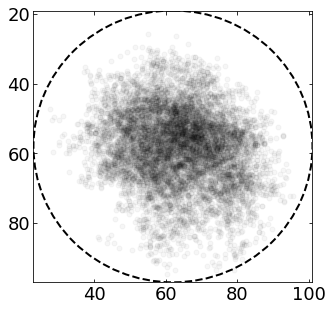

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
circle = plt.Circle((xm, ym), rm, color='k', lw=2, ls='--', fill=False)
ax.add_patch(circle)
ax.plot(f.x, f.y, 'k.', alpha=0.035)
ax.set_xlim(xm-rm, xm+rm)
ax.set_ylim(ym+rm, ym-rm)
#ax.set_xlabel('x [px]')
#ax.set_ylabel('y [px]')
plt.show()

## Step size analysis

In [20]:
# Trap center from to mask
print('xm = %d\nym = %d' % (metadata['pp_mask_x'], metadata['pp_mask_y']))

xm = 62
ym = 62


In [21]:
f = f.sort_values(['particle', 'frame'])

In [22]:
df = f[['x', 'y', 'particle', 'frame']].diff()
df['d'] = np.sqrt((f['x']-xm)**2 + (f['y']-ym)**2)
# unit vectors in radial and tangential direction
df['er_x'] = (f['x']-xm)/df['d']
df['er_y'] = (f['y']-ym)/df['d']
df['et_x'] = (f['y']-ym)/df['d']
df['et_y'] = -(f['x']-xm)/df['d']
# append orientation
df['phi'] = f['orientation']
# keep only the deltas of the same particle
df = df[df['particle'] == 0]
# rename the columns
df.rename(columns={'x': 'dx', 'y': 'dy', 'frame': 'dframe'}, inplace=True)

In [23]:
#df.head()

In [24]:
# displacement vectors projected onto radial and tangential direction to the trap center
df['dr'] = (df['er_x']*df['dx'] + df['er_y']*df['dy'])/df['dframe']
df['dt'] = (df['et_x']*df['dx'] + df['et_y']*df['dy'])/df['dframe']

## Displacment histograms with respect to the orientation

In [25]:
# displacement vectors projected onto the orientation vector
df['ds'] = (np.sin(df['phi'])*df['dx'] + np.cos(df['phi'])*df['dy'])/df['dframe']
df['dp'] = (-np.cos(df['phi'])*df['dx'] + np.sin(df['phi'])*df['dy'])/df['dframe']

In [26]:
ds = np.array(df['ds'])
dp = np.array(df['dp'])

## Import temperature simulation

In [39]:
import scipy.interpolate

data = np.loadtxt('../Data2/Temperature_Simulation/Temperature_Map_Ring_Time_Dependent_Top_View_Slices.txt', skiprows=9)

time = 2.5 # ms
z = (data[:,2]*10).astype(int)

t_map_tmean = []
t_profile_tmean = []

for z_slice in np.linspace(0,9,3).astype(int):
    x = data[z==z_slice, 0]
    y = data[z==z_slice, 1]
    t_tmean = data[z==z_slice, 3:].mean(axis=1) # mean over all timesteps 

    num = 250
    xi = np.linspace(-25, 25, num)
    t_profile_tmean.append(scipy.interpolate.griddata((x, y), t_tmean, (xi, 0), method='linear'))
    
    
t_profile_tmean_zmean = 0
for i in range(3):
    t_profile_tmean_zmean += t_profile_tmean[i]

t_profile_tmean_zmean /= 3

In [40]:
def t_profile(r, alpha, T_center):
    return alpha/2*r**2 + T_center

ri = 5 # µm
ro = 6 # µm

## Radial position distribution

In [41]:
d = np.array(df['d'])

$P_\mathrm{R}(d) = S_\mathrm{T}\alpha\,d\,\mathrm{exp}\left(-\dfrac{S_\mathrm{T}\alpha}{2}d^2\right) \qquad \sigma^2 = 1/S_\mathrm{T}\alpha$

In [48]:
#alpha = 0.019

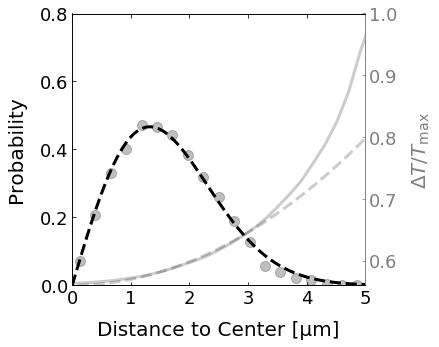

In [46]:
fig, ax1 = plt.subplots(1, 1, figsize=(5.25,5))

# histogram
nbins = 20
bins = np.linspace(0,5,nbins)
hist_d, bin_edges = np.histogram(scale*d, bins=bins, normed=1)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit
(a, sigma), _ = curve_fit(rayleigh, centers, hist_d) #, p0=[800,0,1]
fit_x = np.linspace(0, 5, 100)
fit_y = rayleigh(fit_x, a, sigma)

ax1.plot(centers, hist_d, 'o', c='k', alpha=0.25)
ax1.plot(fit_x, fit_y, 'k--', label='Rayleigh Dist.')

ax1.set_xlabel('Distance to Center [µm]')
ax1.set_ylabel('Probability')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 0.8)
#ax.legend()

ax2 = ax1.twinx()
ax2.plot(xi, t_profile(xi, 0.019, 0.56), '--', c='k', alpha=0.2)
ax2.plot(xi, t_profile_tmean_zmean/np.max(t_profile_tmean_zmean), '-', c='k', alpha=0.2)
ax2.set_ylim(0.56, 1.0)
ax2.set_ylabel('$\Delta T/T_\mathrm{max}$', color='0.5')

ax2.spines['right'].set_color('0.5')
ax2.tick_params('y', colors='0.5')
ax1.spines['right'].set_color('0.5')
ax2.spines['right'].set_color('0.5')

plt.savefig('../Figures/Radial_Position_Distribution_v2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [49]:
alpha = 0.38

### Soret coefficient from curvature

See Temperature_Measurement/Temperature_200nm_PS.ipynb

$S_\mathrm{T} = 1/(\sigma^2\alpha)$

In [115]:
alpha = 0.38

In [116]:
ST = 1/(sigma**2*alpha)
print('ST = %.3f 1/K' % (ST))

ST = 1.861 1/K


## Plots for position + padial distribution

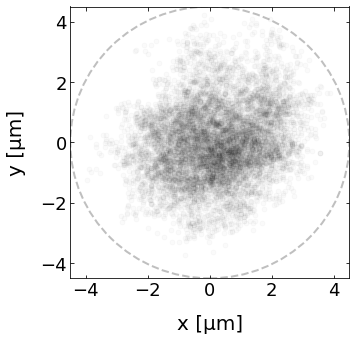

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
circle = plt.Circle((0, 0), rm*scale, color='0.75', lw=2, ls='--', fill=False)
ax.add_patch(circle)
#circle = plt.Circle((0, 0), (rm+10)*scale, color='k', lw=1, ls='-', fill=False)
#ax.add_patch(circle)
ax.plot((f.x-xm)*scale, (f.y-ym)*scale, 'k.', alpha=0.02, ms=10)
ax.set_xlim(-rm*scale, rm*scale)
ax.set_ylim(-rm*scale, rm*scale)
#ax.set_xlim(0, dimx)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
#ax.set_ylim(dimy, 0)
plt.savefig('../Figures/Position_Distribution_Overlay.png', dpi=300, bbox_inches='tight', pad_inches=0.025) # transparent=True
plt.show()

In [52]:
plt.rcParams.update({'axes.labelsize': 30,
                     'xtick.labelsize' : 30,
                     'ytick.labelsize' : 30,}) 

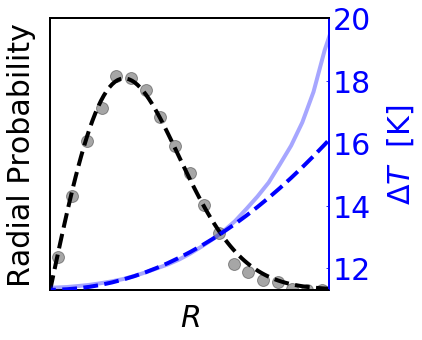

In [62]:
fig, ax1 = plt.subplots(1, 1, figsize=(5.,5))


# histogram
nbins = 20
bins = np.linspace(0,5,nbins)
hist_d, bin_edges = np.histogram(scale*d, bins=bins, normed=1)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit
(a, sigma), _ = curve_fit(rayleigh, centers, hist_d) #, p0=[800,0,1]
fit_x = np.linspace(0, 5, 100)
fit_y = rayleigh(fit_x, a, sigma)

ax1.plot(centers, hist_d, 'o', c='k', ms=12, alpha=0.35)
ax1.plot(fit_x, fit_y, 'k--', label='Rayleigh Dist.', lw=4)

ax1.set_xlabel('$R$')
ax1.set_ylabel('Radial Probability', color='k')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 0.6)
#ax.legend()

tmax = 20.2
ax2 = ax1.twinx()
ax2.plot(xi, tmax*t_profile(xi, 0.019, 0.56), '--', c='b', lw=4, alpha=1.0)
ax2.plot(xi, tmax*t_profile_tmean_zmean/np.max(t_profile_tmean_zmean), '-', c='b', lw=4, alpha=0.35)
ax2.axes.get_yaxis().set_ticks([12,14,16,18,20])
ax2.set_ylim(0.56*tmax, 20)
ax2.set_ylabel('$\Delta T$  [K]', color='b') # /T_\mathrm{max}


ax1.spines['left'].set_color('k')
ax1.spines['left'].set_color('k')
ax2.spines['left'].set_color('k')

ax2.spines['right'].set_color('b')
ax2.tick_params('y', colors='b')
ax1.spines['right'].set_color('b')
ax2.spines['right'].set_color('b')

ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticks([])

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)

plt.savefig('../Figures/Radial_Position_Distribution_Overlay.pdf', bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [65]:
plt.rcParams.update({'axes.labelsize': 20,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,}) 

## Step size distribution in radial and tangential direction

In [66]:
dr = np.array(df['dr'])
dt = np.array(df['dt'])

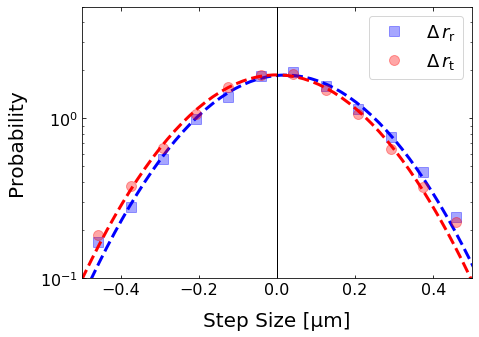

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
bins = np.linspace(-1,1,25)
hist_dp, bin_edges = np.histogram(dr*scale, bins=bins, normed=1)
hist_dt, _ = np.histogram(dt*scale, bins=bins, normed=1)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

(a_s, x0_s, sigma_s), _ = curve_fit(gauss, centers, hist_dp) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_s, x0_s, sigma_s)
ax.plot(centers, hist_dp, 's', c='b', label='$\Delta\,r_\mathrm{r}$', alpha=0.35)
ax.plot(fit_x, fit_y, 'b--')

(a_p, x0_p, sigma_p), _ = curve_fit(gauss, centers, hist_dt) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_p, x0_p, sigma_p)

ax.plot(centers, hist_dt, 'o', c='r', label='$\Delta\,r_\mathrm{t}$', alpha=0.35)
ax.plot(fit_x, fit_y, c='r', ls='--')

ax.set_yscale('log')
#ax.set_ylim(ymin=0)
ax.axvline(0, c='k', ls='-', lw=1)
ax.set_ylim(0.1, 5)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('Step Size [µm]')
ax.set_ylabel('Probability')
#ax.get_yaxis().set_ticks([])
ax.legend()
plt.savefig('../Figures/Radial_Tangential_Probability.pdf', bbox_inches='tight', pad_inches=0.025)
plt.show()

In [68]:
print('vT = %.3f µm/s' % (x0_s/exposure))

vT = 0.700 µm/s


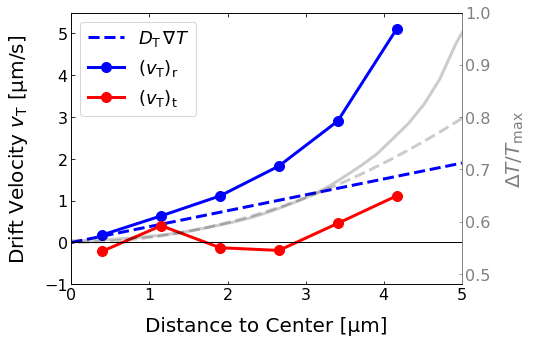

In [76]:
fig, ax1 = plt.subplots(1, 1, figsize=(7,5))
bins = 6
x = np.linspace(0,5,100)
DT = 0.8 # DT = ST*D see below
y = DT*alpha*x
bin_means_dr, bin_edges, _ = stats.binned_statistic(scale*d, scale*dr, statistic='mean', bins=bins, range=None) # range=(0,3.25/scale)
bin_means_dt, bin_edges, _ = stats.binned_statistic(scale*d, scale*dt, statistic='mean', bins=bins, range=None) # range=(0,3.25/scale)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
ax1.plot(x, y, 'b--', label=r'$D_\mathrm{T}\,\nabla T$', alpha=1)
ax1.plot(centers, bin_means_dr/exposure, 'bo-', alpha=1, label='$(v_\mathrm{T})_\mathrm{r}$')
ax1.plot(centers, bin_means_dt/exposure, 'ro-', alpha=1, label='$(v_\mathrm{T})_\mathrm{t}$')
ax1.axhline(0, c='k', ls='-', lw=1)
ax1.set_xlabel('Distance to Center [µm]')
ax1.set_xlim(0, 5)
ax1.set_ylabel('Drift Velocity $v_\mathrm{T}$ [µm/s]')
#ax.set_yticks(np.arange(-0.5, 2, 0.5))
ax1.set_ylim(-1, 5.5)
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(xi, t_profile(xi, 0.019, 0.56), '--', c='k', alpha=0.2)
ax2.plot(xi, t_profile_tmean_zmean/np.max(t_profile_tmean_zmean), '-', c='k', alpha=0.2)
ax2.set_ylim(0.48, 1.0)
ax2.set_ylabel('$\Delta T/T_\mathrm{max}$', color='0.5')

ax2.spines['right'].set_color('0.5')
ax2.tick_params('y', colors='0.5')
ax1.spines['right'].set_color('0.5')
ax2.spines['right'].set_color('0.5')

plt.savefig('../Figures/Drift_Velocity.pdf', bbox_inches='tight', pad_inches=0.025)
plt.show()

### Diffusion constant $D_\mathrm{t}$ from  tangential step size distribution

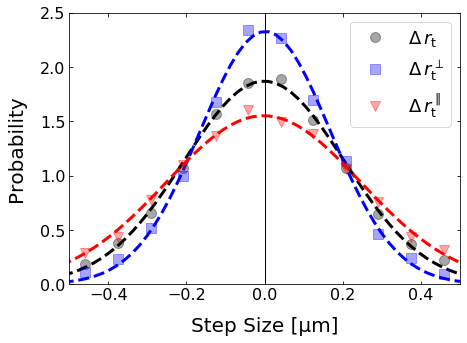

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# Histograms
nbins = 25
bins = np.linspace(-1,1,nbins)
hist_dt, bin_edges = np.histogram(dt*scale, bins=bins, normed=1)
hist_ds, _ = np.histogram(ds*scale, bins=bins, normed=1)
hist_dp, _ = np.histogram(dp*scale, bins=bins, normed=1)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])


# Fits
(a, x0, sigma), _ = curve_fit(gauss, centers, hist_dt) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a, x0, sigma)
ax.plot(fit_x, fit_y, 'k--')
ax.plot(centers, hist_dt, 'o', c='k', label='$\Delta\,r_\mathrm{t}$', alpha=0.35)

(a_s, x0_s, sigma_s), _ = curve_fit(gauss, centers, hist_ds, p0=[1,0,1]) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_s, x0_s, sigma_s)
ax.plot(fit_x, fit_y, 'b--')
ax.plot(centers, hist_ds, 's', c='b', label='$\Delta\,r_\mathrm{t}^\perp$', alpha=0.35)

(a_p, x0_p, sigma_p), _ = curve_fit(gauss, centers, hist_dp, p0=[1,0,1]) #, p0=[800,0,1]
fit_x = np.linspace(centers.min(), centers.max(), 100)
fit_y = gauss(fit_x, a_p, x0_p, sigma_p)
ax.plot(fit_x, fit_y, c='r', ls='--')
ax.plot(centers, hist_dp, 'v', c='r', label='$\Delta\,r_\mathrm{t}^\parallel$',  alpha=0.35)

ax.axvline(0, c='k', ls='-', lw=1)
ax.set_xlim(-0.5,0.5)
ax.set_xlabel('Step Size [µm]')
ax.set_ylim(0,2.5)
ax.set_ylabel('Probability')
#ax.get_yaxis().set_ticks([])
ax.legend()
plt.savefig('../Figures/Step_Size_Translation.pdf', bbox_inches='tight', pad_inches=0.0)
plt.show()

$D_\mathrm{t} = \sigma^2/(2\tau)$

In [78]:
Dt = sigma**2/(2*exposure)
print('Dt = %.3f µm^2/s' % (Dt))

Dt = 0.703 µm^2/s


In [79]:
Dt_p = sigma_p**2/(2*exposure)
print('Dt_p = %.3f µm^2/s' % (Dt_p))

Dt_s = sigma_s**2/(2*exposure)
print('Dt_s = %.3f µm^2/s' % (Dt_s))

Dt_p = 1.029 µm^2/s
Dt_s = 0.462 µm^2/s


In [80]:
print('Dt_s/Dt_p = %.3f' % (Dt_s/Dt_p))

Dt_s/Dt_p = 0.449


In [81]:
DT = ST*Dt
print('DT = %.3f µm^2/(K s)' % (DT))

DT = 1.053 µm^2/(K s)


### Histogram

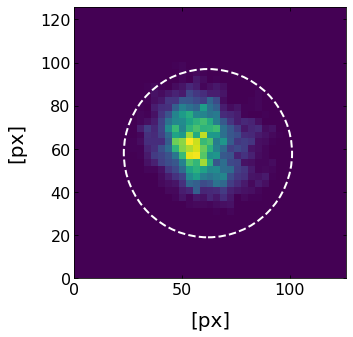

In [82]:
nbin = 40
binx = np.linspace(0, dimx, nbin)
biny = np.linspace(0, dimy, nbin)
#binx = np.linspace(xm-rm,xm+rm, nbin)
#biny = np.linspace(xm-rm,xm+rm, nbin)

h, xedges, yedges, _ = stats.binned_statistic_2d(f.x, f.y, None, 'count', bins=[binx,biny])

fig, ax = plt.subplots(1, 1, figsize=(5,5))
#ax.set_xlim(xm-rm, xm+rm)
#ax.set_ylim(ym+rm, ym-rm)
circle = plt.Circle((xm, ym), rm, color='w', lw=2, ls='--', fill=False)
ax.add_patch(circle)
ax.imshow(h, extent=[0, dimx, 0, dimy])
ax.set_xlabel('[px]')
ax.set_ylabel('[px]')
plt.show()

In [83]:
# find maxium
indices_max = np.unravel_index(h.argmax(), h.shape)

In [84]:
# histogram cross-section in y direction 
data_y = h[indices_max[0]]
data_x = ((0.5*(xedges[1:] + xedges[:-1])) - ym)*scale

### Soret coefficient $S_\mathrm{T}$ from positional distribution

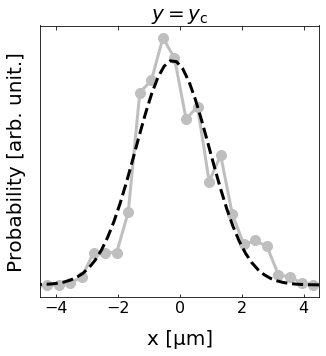

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

# histogram cross-section
ax.plot(data_x, data_y, 'o-', color='0.75')

# fit
(a, x0, sigma), _ = curve_fit(gauss, data_x, data_y, p0=[200,0,1]) #, p0=[800,0,1]
fit_x = np.linspace(-10, 10, 100)
fit_y = gauss(fit_x, a, x0, sigma)
ax.plot(fit_x, fit_y, '--', c='k')

ax.set_title('$y = y_\mathrm{c}$')
ax.set_xlim(-scale*rm, scale*rm)
ax.set_xlabel('x [µm]')
ax.set_ylabel('Probability [arb. unit.]')
ax.get_yaxis().set_ticks([])
ax.legend()
#plt.savefig('../../Figures/.pdf', bbox_inches='tight', pad_inches=0.0)
ax.legend()
plt.show()

$P(d) = \dfrac{2\pi}{S_\mathrm{T}\alpha}\mathrm{exp}\left(-\dfrac{S_\mathrm{T}\alpha}{2}d^2\right) \qquad \sigma^2 = 1/S_\mathrm{T}\alpha$

In [86]:
print('S = %.3f 1/K' % (1/(sigma**2*alpha)))

S = 1.489 1/K


## Rotational diffusion

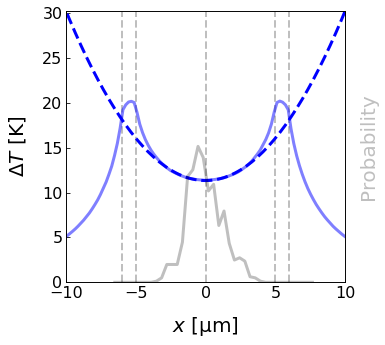

In [96]:
tmax = 20.2

idx = np.where((xi > -3.5) & (xi < 3.5))
(alpha, tcenter), _ = curve_fit(t_profile, xi[idx], tmax*t_profile_tmean_zmean[idx]/np.max(t_profile_tmean_zmean)) #, p0=[800,0,1]
fit_tr = t_profile(xi, alpha, tcenter)

fig, ax1 = plt.subplots(1, 1, figsize=(5,5))

ax1.axvline(x=0, c='0.75', ls='--', lw=2)
ax1.axvline(x=-ri, c='0.75', ls='--', lw=2)
ax1.axvline(x=-ro, c='0.75', ls='--', lw=2)
ax1.axvline(x=ri, c='0.75', ls='--', lw=2)
ax1.axvline(x=ro, c='0.75', ls='--', lw=2)
#plt.plot(xi, 5.81*tmax*t_profile_timestep/np.max(t_profile_timestep), '0.75', label='static')
plt.plot(xi, tmax*t_profile_tmean_zmean/np.max(t_profile_tmean_zmean), 'b', alpha=0.5)
ax1.plot(xi, fit_tr, c='b', ls='--')
ax1.set_xlabel(r'$x$ [µm]')
ax1.set_ylabel(r'$\Delta T$ [K]')
ax1.set_xlim(-10,10)
ax1.set_ylim(0, 1.5*tmax)

ax2 = ax1.twinx()
ax2.plot(data_x, data_y/np.max(data_y), '-', c='k', alpha=0.25)
ax2.set_ylim(0, 2)
ax2.set_ylabel('Probability', color='0.75')
ax2.axes.get_yaxis().set_ticks([])

#ax.set_title(r'$z=0$');
#ax.legend(loc='upper center', framealpha=1)
plt.savefig('../Figures/Temperature_Profile+Probability.pdf', bbox_inches='tight', pad_inches=0.025);
#plt.savefig('../../Figures/Temperature_Profile_Ring_10µm_r.png', dpi=300, bbox_inches='tight', pad_inches=0.025);
plt.show()

## Rotational diffusion

In [217]:
dphi = np.array(f[['orientation']].diff().dropna())

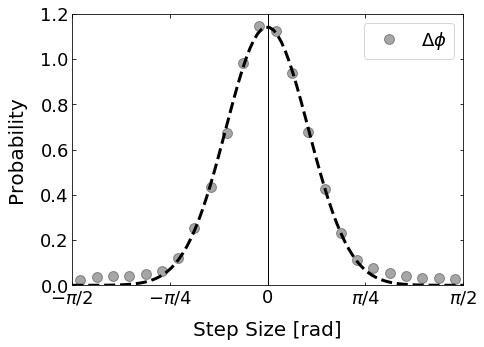

In [234]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

# histogram
bins = np.linspace(-pi/2,pi/2,25)
hist_dphi, bin_edges = np.histogram(dphi, bins=bins, normed=1)
centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# fit
(a, x0, sigma), _ = curve_fit(gauss, centers, hist_dphi) #, p0=[800,0,1]
fit_x = np.linspace(bins.min(), bins.max(), 100)
fit_y = gauss(fit_x, a, x0, sigma)

ax.plot(fit_x, fit_y, '--', c='k')
ax.plot(centers, hist_dphi, 'o', c='k', alpha=0.35, label='$\Delta\phi$') # /np.max(hist_dphi)

ax.axvline(0, c='k', ls='-', lw=1)
ax.set_xlim(bins.min(), bins.max())
ax.set_ylim(ymin=0)
ax.set_xticks([-0.5*np.pi, -0.25*np.pi, 0, 0.25*np.pi, 0.5*np.pi])
ax.set_xticklabels(['$-\pi/2$', '$-\pi/4$', '0', '$\pi/4$', '$\pi/2$'])
ax.set_xlabel('Step Size [rad]')
ax.set_ylabel('Probability')
#ax.get_yaxis().set_ticks([])
ax.legend()
plt.savefig('../Figures/Step_Size_Rotation.pdf', bbox_inches='tight', pad_inches=0.025)
plt.show()

$D_\mathrm{r} = \sigma^2/(2\tau)$

In [87]:
Dr_exp = sigma**2/(2*exposure)
print('Dr = %.3f rad^2/s' % (Dr_exp))

Dr = 1.833 rad^2/s
